# Bayesian Optimization
Idea: Use bayesian optimization for (wrapper) feature selection.

In [235]:
from sklearn import datasets
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from bayes_opt import BayesianOptimization
from itertools import chain, combinations
from itertools import compress
from skopt import gp_minimize
from skopt.space import Integer
import matplotlib.pyplot as plt

## 0. Hyperparameters

In [237]:
k_features = 7 # number of features which we want to get

## 1. Choose dataset

In [238]:
# regression dataset
dataset = datasets.load_boston()

In [5]:
# classification dataset
dataset = datasets.load_wine()

In [6]:
# classification dataset
dataset = datasets.load_breast_cancer()

## 2. Import dataset

In [239]:
# define which dataset should be used
data = dataset.data
data_target = dataset.target
feature_names = dataset.feature_names

data_frame = pd.DataFrame(data, columns = feature_names)
data_frame['Target'] = data_target
X = data_frame.drop("Target", 1)       # feature matrix
y = data_frame['Target'] 
data_frame.head()

#print(data)
#print(target_matrix)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 3. Classical Feature Selection Algorithms

### 3.1 Sequential Forward Selection (mlxtend SFS)
- https://github.com/rasbt/mlxtend

In [240]:
forward_selection = SFS(LinearRegression(),
          k_features=k_features,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 0)

In [241]:
forward_selection.fit(X, y)
res_sfs = tuple(sorted(forward_selection.k_feature_names_))
res_sfs

('B', 'CHAS', 'DIS', 'LSTAT', 'NOX', 'PTRATIO', 'RM')

### 3.2 Recursive Feature Elimination (sklearn RFE)
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [242]:
rfe_selection = RFE(LinearRegression(),
               n_features_to_select=k_features,
               step=1)

In [243]:
rfe_selection.fit(X, y)
rfe_support = rfe_selection.support_

# convert to k-feature-names tuple
res_rfe_temp = []
for i in range(0,len(feature_names)):
    if rfe_support[i]:
        res_rfe_temp.append(feature_names[i])
res_rfe = tuple(sorted(res_rfe_temp)) # convert to tuple
res_rfe

('CHAS', 'DIS', 'LSTAT', 'NOX', 'PTRATIO', 'RAD', 'RM')

## 4. Bayesian Optimization Algorithm

### 4.1 Create feature-subsets (wrapper)

In [244]:
#s = feature_names 
#wrapper = list(combinations(s, k_features))

### 4.2  fmfn / BayesianOptimization Package 
- https://github.com/fmfn/BayesianOptimization

In [245]:
#pbounds_old = {'x': (0, len(wrapper)-1)}
#def black_box_function_bay_opt_old(x):
#    x = round(x)
#    filteredX = X[X.columns[X.columns.isin(wrapper[x])]] # use only selected features
#    model = LinearRegression().fit(filteredX, y)
#    return model.score(filteredX, y) # coefficient of determination


In [246]:
def black_box_function_bay_opt(**kwargs):
    current_features = []
    for k, v in kwargs.items():
        if bool(round(v)):
            current_features.append(k)
    filtered_X = X[X.columns[X.columns.isin(current_features)]]
    model = LinearRegression().fit(filtered_X, y)
    return model.score(filtered_X, y) # coefficient of determination

In [247]:
pbounds = {}
for feature_name in feature_names:
    pbounds[feature_name] = (0,1)

In [266]:
optimizer_fmfn = BayesianOptimization(
    f=black_box_function_bay_opt,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=123,
)

In [267]:
optimizer_fmfn.maximize(
    init_points=5,
    n_iter=30,
    acq = 'poi',
)

score_fmfn = optimizer_fmfn.max["target"]
res_fmfn_list = []
for k, v in optimizer_fmfn.max["params"].items():
    if bool(round(v)):
        res_fmfn_list.append(k)

res_fmfn = tuple(sorted(res_fmfn_list))

#print(optimizer_fmfn.max["target"])
#print(round(optimizer_fmfn.max["params"]["x"]))

#res_fmfn = tuple(sorted(wrapper[round(optimizer_fmfn.max["params"]["x"])]))
print(score_fmfn)
res_fmfn

|   iter    |  target   |    AGE    |     B     |   CHAS    |   CRIM    |    DIS    |   INDUS   |   LSTAT   |    NOX    |  PTRATIO  |    RAD    |    RM     |    TAX    |    ZN     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  2        |  0.6971   |  0.05968  |  0.398    |  0.738    |  0.1825   |  0.1755   |  0.5316   |  0.5318   |  0.6344   |  0.8494   |  0.7245   |  0.611    |  0.7224   |  0.323    |
|  5        |  0.7027   |  0.6031   |  0.5451   |  0.3428   |  0.3041   |  0.417    |  0.6813   |  0.8755   |  0.5104   |  0.6693   |  0.5859   |  0.6249   |  0.6747   |  0.8423   |
0.7027122835819737


('AGE', 'B', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RAD', 'RM', 'TAX', 'ZN')

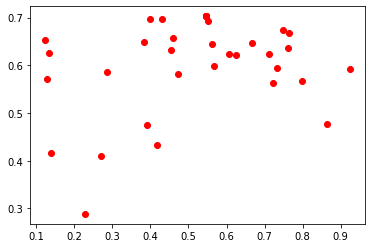

In [250]:
plot_x = []
plot_y = []
for element in optimizer_fmfn.res:
    plot_y.append(element['target'])
    plot_x.append(element['params']['B'])

plt.plot(plot_x, plot_y, 'ro')
plt.show()

### 4.3 scikit-optimize (skopt)
- https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

In [251]:
#def black_box_function_scikit_optimize_old(x):
#    x = x[0]
#    
#    filteredX = X[X.columns[X.columns.isin(wrapper[x])]] # use only selected features
#    model = LinearRegression().fit(filteredX, y)
#    return 1-model.score(filteredX, y) # coefficient of determination


In [252]:
space  = []
for feature_name in feature_names:
    space.append(Integer(0, 1, name=feature_name))

In [264]:
def black_box_function_scikit_optimize(*args):
    current_features = list(compress(feature_names, args[0]))
    #print(current_features)
    filtered_X = X[X.columns[X.columns.isin(current_features)]]
    model = LinearRegression().fit(filtered_X, y)
    score = 1-model.score(filtered_X, y) # coefficient of determination
    #print(score)
    return score

In [265]:
optimizer_skopt = gp_minimize(black_box_function_scikit_optimize, # the function to minimize
                  space,      # the bounds on each dimension of x
                  acq_func="PI",      # the acquisition function
                  n_calls=50,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  #noise=0.1**2,       # the noise level (optional)
                  random_state=123,  # the random seed
                  verbose=False)  

score_skopt = 1-optimizer_skopt.fun
res_skopt = tuple(sorted(compress(feature_names, optimizer_skopt.x)))
print(score_skopt)
print(res_skopt)

/home/patrick/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/patrick/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/patrick/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/patrick/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/patrick/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has be

0.7405837482416913
('AGE', 'B', 'CHAS', 'CRIM', 'DIS', 'LSTAT', 'NOX', 'PTRATIO', 'RAD', 'RM', 'TAX', 'ZN')


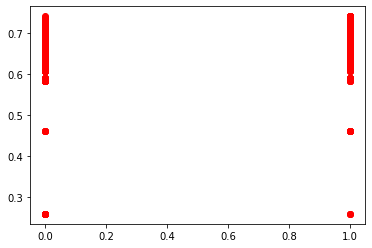

In [258]:
plot_x = optimizer_skopt.x_iters
plot_y = [1-i for i in optimizer_skopt.func_vals]
plt.plot(plot_x , plot_y, 'ro')
plt.show()

## 5. Results

In [268]:
# forward selection algorithm
res_sfs

('B', 'CHAS', 'DIS', 'LSTAT', 'NOX', 'PTRATIO', 'RM')

In [269]:
# recursive feature elimination
res_rfe

('CHAS', 'DIS', 'LSTAT', 'NOX', 'PTRATIO', 'RAD', 'RM')

In [270]:
# fmfn bayesian optimization
res_fmfn

('AGE', 'B', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RAD', 'RM', 'TAX', 'ZN')

In [272]:
# skopt bayesian optimization
res_skopt

('AGE',
 'B',
 'CHAS',
 'CRIM',
 'DIS',
 'LSTAT',
 'NOX',
 'PTRATIO',
 'RAD',
 'RM',
 'TAX',
 'ZN')